<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Text_neural2/TextClassification_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'news-articles-classification-dataset-for-nlp-and-ml:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4626328%2F7882142%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240820%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240820T172053Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2310c609f7e8bfc62727776434eadc73ef1594456934e24dc885ab218458eeab07ba190452cda5391fc4df11124367e052bb4a948fe1871bf7f75c3d3fb764c09cb1610760aa6f86d5c99772b37c46fb613dbacf2881a5dcf47b7b5b3417761227aac66d212bdf8d28c09d8da6b0024aa2ec15de25cd2d18b151b3182354abc9034ede964035d05e968c7a11896ed42f823661c97747c6ccf9ed06708c4e183f9e9cae47933283bb3d6c570f51696bcfc33c0bc619ee8fe133bcd98d0d6b4f1476d49ae834e31804ddf72e4e5a5d06a54f89974039d69c3932675548ecc62dd4afc22045d9043552855409ce2bfa726af6233c588eb2e9cd95398e44e1cf86bd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[==================================================] 5837001 bytes downloaded
Downloaded and uncompressed: news-articles-classification-dataset-for-nlp-and-ml
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input\news-articles-classification-dataset-for-nlp-and-ml\business_data.csv
/kaggle/input\news-articles-classification-dataset-for-nlp-and-ml\education_data.csv
/kaggle/input\news-articles-classification-dataset-for-nlp-and-ml\entertainment_data.csv
/kaggle/input\news-articles-classification-dataset-for-nlp-and-ml\sports_data.csv
/kaggle/input\news-articles-classification-dataset-for-nlp-and-ml\technology_data.csv


In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
business_df = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv')
education_df = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv')
entertainment_df = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv')
sports_df = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv')
technology_df = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv')

combined_df = pd.concat([business_df, education_df, entertainment_df, sports_df, technology_df], ignore_index=True)

combined_df

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
...,...,...,...,...,...
9995,Vivaldi’s privacy and customisability-focused ...,The Vivaldi browser is now available on iOS an...,"Vivaldi, the free browser founded by Opera co-...",https://indianexpress.com/article/technology/t...,technology
9996,"From Meta Quest 3 to Ray Ban Smart Glasses, he...",The future is here. Meta unveils its next-gen ...,"Meta has concluded its Connect 2023 event, unv...",https://indianexpress.com/article/technology/t...,technology
9997,Samsung Galaxy S24 rumoured to launch on Janua...,Samsung might shift the launch window of its u...,Samsung has been launching its Galaxy S series...,https://indianexpress.com/article/technology/m...,technology
9998,"‘We continuously iterate… building prototypes,...",Dyson's success in floorcare tech lies in inno...,"“When things don’t go as planned, we return to...",https://indianexpress.com/article/technology/t...,technology


In [5]:
combined_df['text'] = combined_df['headlines'].fillna('') + " " + combined_df['description'].fillna('') + " " + combined_df['content'].fillna('')

combined_df.rename(columns={'category': 'labels'}, inplace=True)

df = combined_df[['labels', 'text']]

df

,labels,text
0,business,Nirmala Sitharaman to equal Morarji Desai’s re...
1,business,"‘Will densify network, want to be at least no...."
2,business,Air India group to induct an aircraft every si...
3,business,Red Sea woes: Exporters seek increased credit ...
4,business,Air India group to induct a plane every 6 days...
...,...,...
9995,technology,Vivaldi’s privacy and customisability-focused ...
9996,technology,"From Meta Quest 3 to Ray Ban Smart Glasses, he..."
9997,technology,Samsung Galaxy S24 rumoured to launch on Janua...
9998,technology,"‘We continuously iterate… building prototypes,..."


In [6]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext
from torchtext.vocab import GloVe


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=500):
        self.X = X
        self.y = y
        self.max_len = max_len

        self.label_encoder = LabelEncoder().fit(y)
        self.vocab = torchtext.vocab.GloVe(name='840B', dim=300)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)

        text = self.X.iloc[idx]
        tokens = text.split()

        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)

            tokens += ['<pad>'] * diff

        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)

        return X, label[0]


dataset = MyDataset(df['text'], df['labels'])

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [7]:
dataset[0][0].shape

torch.Size([500, 300])

In [8]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [9]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [10]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
from torch import Tensor


# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(1, max_len, d_model)
#         pe[0, :, 0::2] = torch.sin(position * div_term)
#         pe[0, :, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Arguments:
#             x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
#         """
#         x = x + self.pe[:, :x.size(1)]
#         return self.dropout(x)

In [11]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()

        #self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=128),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim * max_len, num_classes)

    def forward(self, x):
        #out = self.pos_encoder(x)
        out = self.encoder(x)
        out = self.flatten(out)
        out = self.linear1(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(encoding_dim=300, max_len=500, num_classes=5).to(device)
model

TextClassifier(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=150000, out_features=5, bias=True)
)

In [12]:
params_num = 0

for param in model.parameters():
    size = param.size()

    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

1189633

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [14]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device).float()
            y    = batch[1].to(device).long()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device).float()
                y    = batch[1].to(device).long()
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.000100), epochs=10, device=cuda



C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch    1   25sec	loss:      0.422	val_loss:      0.147	accuracy_score:      0.894	val_accuracy_score:      0.963	
Epoch    2   26sec	loss:     0.0436	val_loss:       0.13	accuracy_score:      0.987	val_accuracy_score:      0.958	
Epoch    3   25sec	loss:     0.0156	val_loss:      0.145	accuracy_score:      0.995	val_accuracy_score:      0.964	
Epoch    4   25sec	loss:    0.00837	val_loss:      0.115	accuracy_score:      0.997	val_accuracy_score:      0.969	
Epoch    5   26sec	loss:    0.00189	val_loss:      0.112	accuracy_score:          1	val_accuracy_score:      0.972	
Epoch    6   26sec	loss:   0.000996	val_loss:      0.114	accuracy_score:          1	val_accuracy_score:      0.972	
Epoch    7   26sec	loss:   0.000731	val_loss:      0.115	accuracy_score:          1	val_accuracy_score:      0.974	
Epoch    8   26sec	loss:   0.000595	val_loss:      0.114	accuracy_score:          1	val_accuracy_score:      0.973	
Epoch    9   26sec	loss:   0.000468	val_loss:      0.119	accuracy_score:

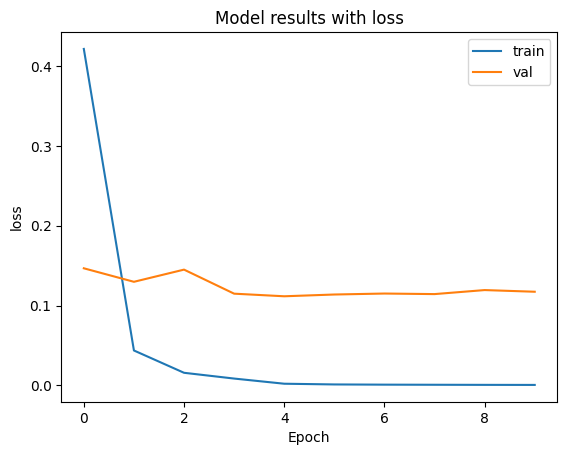

In [16]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

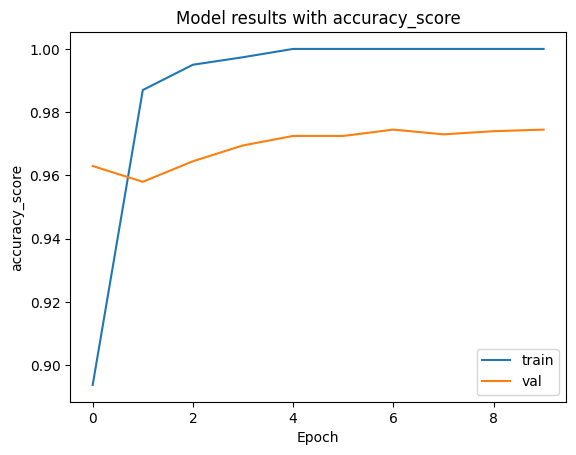

In [17]:
plot_metric(history, 'accuracy_score')

[]

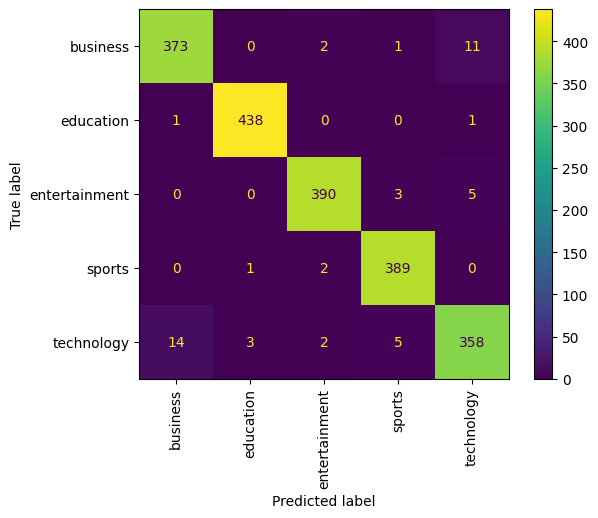

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

               precision    recall  f1-score   support

     business       0.96      0.96      0.96       387
    education       0.99      1.00      0.99       440
entertainment       0.98      0.98      0.98       398
       sports       0.98      0.99      0.98       392
   technology       0.95      0.94      0.95       382

     accuracy                           0.97      1999
    macro avg       0.97      0.97      0.97      1999
 weighted avg       0.97      0.97      0.97      1999

